In [23]:
from ThesisPackage.Environments.collectors.collectors_env_discrete import Collectors
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
import torch
import numpy as np
import time
import os

In [30]:
def make_env(sequence_length=5, vocab_size=4):
    max_episode_steps = 2048
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_episode_steps, timestep_countdown=15)
    # env = ParallelFrameStack(env, 4)
    return env

In [25]:
from tqdm import tqdm
def run_experiment(agent, env, render=False, noise=False, epochs=50):
    lengths = []
    sequence_length = env.sequence_length

    for i in tqdm(range(epochs), desc="Running Experiment"):
        obs, info = env.reset()
        obs = np.array([obs[agent] for agent in env.agents])
        obs = torch.Tensor(obs)

        state = env.state()
        state = np.array([state[agent] for agent in env.agents])
        state = torch.Tensor(state)

        done = [False]
        while not any(done):
            action, logprob, _, value = agent.agent.get_action_and_value(obs, state)
            action = action.cpu().numpy()

            action = {agent: action[i] for i, agent in enumerate(env.agents)}
            if render:
                try:
                    env.render()
                    time.sleep(0.02)
                except IndexError:
                    pass
            
            if noise:
                for cur_agent in env.agents:
                    action[cur_agent][2:] = np.random.randint(0, env.vocab_size, size=sequence_length).astype(np.float32)
            obs, rewards, terminated, truncated, info = env.step(action)
            obs = np.array([obs[agent] for agent in env.agents])
            obs = torch.Tensor(obs)

            state = env.state()
            state = np.array([state[agent] for agent in env.agents])
            state = torch.Tensor(state)

            terminated = [terminated[agent] for agent in env.agents]
            truncated = [truncated[agent] for agent in env.agents]
            if any(truncated) or any(terminated):
                lengths.append(env.timestep)
                done = [True]
                break
    return lengths

In [26]:
results = {"Language":{}, "No Language":{}}

In [27]:
env = make_env()
agent = PPO_Multi_Agent_Centralized(env)
agent.agent.load_state_dict(torch.load('/Users/cowolff/Documents/GitHub/ma.pong_rl/models/collectors.pt'))
agent.agent.eval()

lengths = run_experiment(agent, env, noise=True, epochs=1000)
results["Language"]["Noise"] = np.average(lengths)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Running Experiment: 100%|██████████| 1000/1000 [00:43<00:00, 22.96it/s]


In [28]:
lengths = run_experiment(agent, env, noise=False, epochs=1000)
results["Language"]["No Noise"] = np.average(lengths)

Running Experiment: 100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]


In [31]:
no_lang_env = make_env(sequence_length=0)
no_lang_agent = PPO_Multi_Agent_Centralized(no_lang_env)
no_lang_agent.agent.load_state_dict(torch.load('/Users/cowolff/Documents/GitHub/ma.pong_rl/models/collectors_no_lang.pt'))
no_lang_agent.agent.eval()

lengths = run_experiment(no_lang_agent, no_lang_env, noise=False, epochs=1000)
results["No Language"]["No Noise"] = np.average(lengths)

Running Experiment: 100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


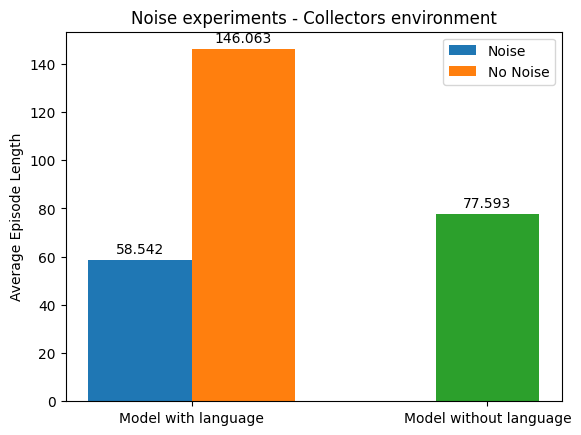

In [35]:
import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots()

# X-axis labels
labels = ["Model with language", "Model without language"]

# Values and positions
positions = np.arange(len(labels))
width = 0.35

# Language data
language_noise = results['Language']['Noise']
language_no_noise = results['Language']['No Noise']
no_language_no_noise = results['No Language']['No Noise']

# Bars
bars1 = ax.bar(positions[0] - width/2, language_noise, width, label='Noise')
bars2 = ax.bar(positions[0] + width/2, language_no_noise, width, label='No Noise')
bars3 = ax.bar(positions[1], no_language_no_noise, width)

# Labels
ax.set_ylabel('Average Episode Length')
ax.set_title('Noise experiments - Collectors environment')
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.legend()

# Display values on top of the bars
for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()
